# 量子位相推定

<Admonition type="note">
  Kento Ueda (15 May 2024)　翻訳：Hotaka Hayashi（30 June 2025）

  この教材では、量子フーリエ変換（QFT）と量子位相推定（QPE）の基本とその実装を学びます。

  和訳版の講義スライドPDFは[こちら](https://github.com/quantum-tokyo/introduction/blob/main/src/courses/utility-scale-quantum-computing/5_quantum-phase-estimation.pdf)です。

  *QPU上の推定ランタイム：7秒*
</Admonition>



## 1. イントロダクション

**量子フーリエ変換 (QFT)**

量子フーリエ変換（QFT）は、古典計算における離散フーリエ変換に対応する量子計算です。これは量子状態の計算基底を、フーリエ変換に基づいた形式へ変換する線型写像です。QFTは量子状態から周期成分の情報を得る効率的な方法として、多くの量子アルゴリズムで重要な役割を果たしています。
QFTは$H$ゲートや制御$P$ゲートなどを用いて、$N$量子ビットに対し$O(N^2)$のゲートで実装されます。これは古典フーリエ変換に対する指数的な加速を示します。

*  **応用**: 巨大整数の素因数分解や離散対数を扱う、ショアのアルゴリズムなどの量子アルゴリズムにおける基礎的な部分を構成しています。

**量子位相推定（QPE）**

量子位相推定は、あるユニタリ行列の固有ベクトルに紐づいた位相を推定するアルゴリズムです。これは量子状態の数学的性質を、計算における応用へとつなげる橋渡しとなるものです。

*  **応用**:ユニタリ行列の固有値を求めたり、量子系のシミュレーションといった問題を解くことができます。

 QFTとQPEは共に、古典コンピュータが現状敵わないような問題を解ける量子アルゴリズムの根幹となるものです。この教材を通して、これらの実装方法を理解していただけます。


## 2. 量子フーリエ変換(QFT)の基礎



In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.quantum_info import Statevector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import Sampler

from numpy import pi
import matplotlib

離散フーリエ変換のアナロジーとして、量子フーリエ変換は$n$量子ビットの量子状態$\vert j \rangle$を以下のように変換します。

$$
QFT_{N}: \vert j \rangle \mapsto \frac{1}{\sqrt{N}}\sum_{k=0}^{N-1}\omega_N^{jk} \vert k \rangle
$$

ここで$N=2^n$, $\omega_N^{jk} = e^{2\pi i \frac{jk}{N}}$です。

ユニタリ行列による表現は以下の通りです：

$$
U_{QFT} = \frac{1}{\sqrt{N}} \sum_{j=0}^{N-1} \sum_{k=0}^{N-1} \omega_N^{jk} \vert k \rangle \langle j \vert
$$



### 2.1. 直感的な理解　<a id="intuition"></a>


QFTはZ基底とフーリエ基底の2つの間での基底変換です。ここで、フーリエ基底とは何を意味しているのでしょうか。

関数$f(x)$のフーリエ変換$F(\omega)$は、$f(x)$を周波数$\omega$の正弦波関数に畳み込みしたものです。簡単に言えば、フーリエ変換は、$f(x)$を正弦または余弦関数から生成するのに、それぞれの周波数成分$\omega$がどのくらい必要になるかを示す関数ということです。QFTが意味するところをよりよく理解するために、以下の4量子ビットを用いた図を考えましょう。

![zbasis-counting.gif](images/zbasis-counting.gif)

計算基底において、それぞれの数字は$|0\rangle$と$|1\rangle$のバイナリで格納されます。

それぞれの量子ビットがフリップする周期が違うことを確認しましょう。
最も左の量子ビットは全ての数字の増加に対してフリップしています。その1つ右は数字が2増加するたびにフリップし、その1つ右は数字が4増加するたびにフリップし、...と続きます。

これらの量子状態に量子フーリエ変換を施すと、フーリエ基底で記述される量子状態となります。

$$
|\text{計算基底の量子状態}\rangle \quad \xrightarrow[]{\text{QFT}} \quad |\text{フーリエ基底の量子状態}\rangle
$$

$$
\text{QFT}|x\rangle = |\widetilde{x}\rangle
$$

（しばしば、フーリエ基底はチルダ(\~)によって表現されます。）

![fourierbasis-counting.gif](images/fourierbasis-counting.gif)

フーリエ基底において格納される数字は、各量子ビットがZ軸まわりに回転する角度を表現します。$|\widetilde{0}\rangle$の状態は、全ての量子ビットが$|{+}\rangle$にあることを表します。上の例のように、4量子ビット状態$|\widetilde{5}\rangle$において、最も左の量子ビットは$\tfrac{5}{2^n} = \tfrac{5}{16}$だけ回転しています（つまり、1周$2\pi$ラジアンの$\tfrac{5}{16}$倍）。その右の量子ビットは、2倍の$\tfrac{10}{16}\times 2\pi$ ラジアンだけ回転しており、その右は...と続いていきます。

それぞれの量子ビットが変化する周期が違うことを、改めて確認しておきましょう。最も左の量子ビット(量子ビット0)は最小の周波数を持ち、最も右が最大の周波数を持ちます。



### 2.2 例: 1-qubit QFT



$N = 2^1 = 2$のケースを見てみましょう。

ユニタリ行列は以下のように書けます。:

$$
\begin{aligned}
U_{QFT} & = \frac{1}{\sqrt{2}} \sum_{j=0}^{1} \sum_{k=0}^{1} \omega_2^{jk} \vert k \rangle \langle j \vert
\\
& = \frac{1}{\sqrt{2}} (\omega_2^{0} \vert 0 \rangle \langle 0 \vert + \omega_2^{0} \vert 0 \rangle \langle 1 \vert + \omega_2^{0} \vert 1 \rangle \langle 0 \vert + \omega_2^{1} \vert 1 \rangle \langle 1 \vert)
\\
& = \frac{1}{\sqrt{2}} (\vert 0 \rangle \langle 0 \vert + \vert 0 \rangle \langle 1 \vert + \vert 1 \rangle \langle 0 \vert - \vert 1 \rangle \langle 1 \vert)
\\
& = H
\end{aligned}
$$

この演算は、アダマールゲート($H$)をかけることと同じです。

### 2.3 QFTのテンソル積による表現



$N = 2^n$次元へ一般化しましょう。$QFT_{N}$は$\vert x \rangle = \vert x_1\ldots x_n \rangle$に対して以下のように作用します。

$$
\begin{aligned}
QFT_N\vert x \rangle & = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1}\omega_N^{xy} \vert y \rangle
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i xy / 2^n} \vert y \rangle ~\text{since}\: \omega_N^{xy} = e^{2\pi i \frac{xy}{N}} \:\text{and}\: N = 2^n
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} e^{2 \pi i \left(\sum_{k=1}^n y_k/2^k\right) x} \vert y_1 \ldots y_n \rangle \:\text{rewriting in fractional binary notation}\: y = y_1\ldots y_n, y/2^n = \sum_{k=1}^n y_k/2^k
\\
& = \frac{1}{\sqrt{N}} \sum_{y=0}^{N-1} \prod_{k=1}^n e^{2 \pi i x y_k/2^k } \vert y_1 \ldots y_n \rangle \:\text{after expanding the exponential of a sum to a product of exponentials,}
\\
& = \frac{1}{\sqrt{N}} \bigotimes_{k=1}^n  \left(\vert0\rangle + e^{2 \pi i x /2^k } \vert1\rangle \right) \:\text{after rearranging the sum and products, and expanding}
\sum_{y=0}^{N-1} = \sum_{y_1=0}^{1}\sum_{y_2=0}^{1}\ldots\sum_{y_n=0}^{1}
\\
& = \frac{1}{\sqrt{N}}
\left(\vert0\rangle + e^{\frac{2\pi i}{2}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^2}x} \vert1\rangle\right)
\otimes
\ldots
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^{n-1}}x} \vert1\rangle\right)
\otimes
\left(\vert0\rangle + e^{\frac{2\pi i}{2^n}x} \vert1\rangle\right)
\end{aligned}
$$



### 2.4 例: 3量子ビットQFT回路の構築

上記の説明からは、QFTの量子回路を作る方法は自明ではありません。ここで、3量子ビットそれぞれの位相が異なる割合で発展することに注意して、この回路を構築してみましょう。もともとの講義資料には多くの図や例が存在しておりますし、さらなる資料は、量子アルゴリズムの基礎コースに含まれる[こちらの講義](/learning/courses/fundamentals-of-quantum-algorithms/phase-estimation-and-factoring/introduction)をご覧ください。

さて、QFTをシミュレータで実行してみましょう。



In [20]:
# Prepare for 3 qubits circuit
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr, cr)

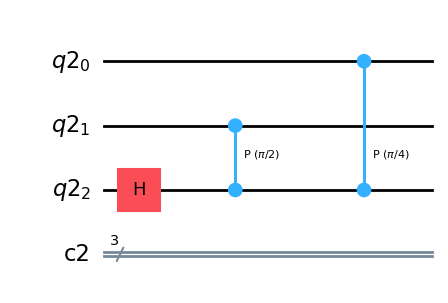

In [21]:
qc.h(2)
qc.cp(pi / 2, 1, 2)  # Controlled-phase gate from qubit 1 to qubit 2
qc.cp(pi / 4, 0, 2)  # Controlled-phase gate from qubit 0 to qubit 2
qc.draw(output="mpl")

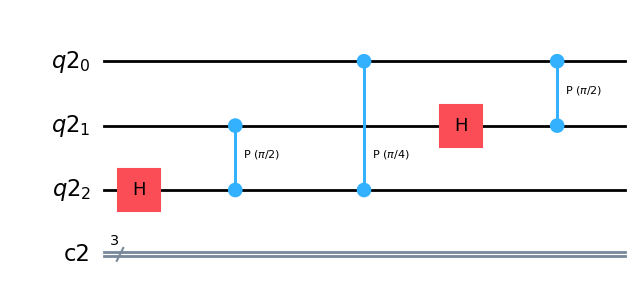

In [22]:
qc.h(1)
qc.cp(pi / 2, 0, 1)  # Controlled-phase gate from qubit 0 to qubit 1

qc.draw(output="mpl")

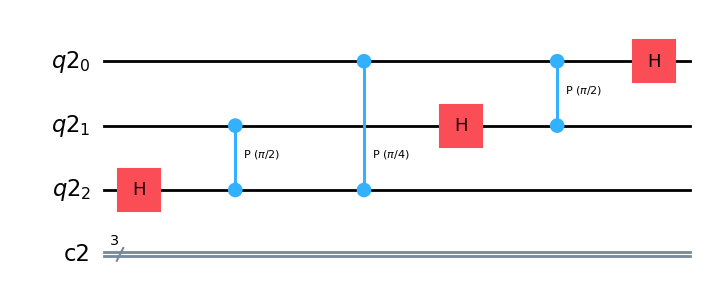

In [23]:
qc.h(0)

qc.draw(output="mpl")

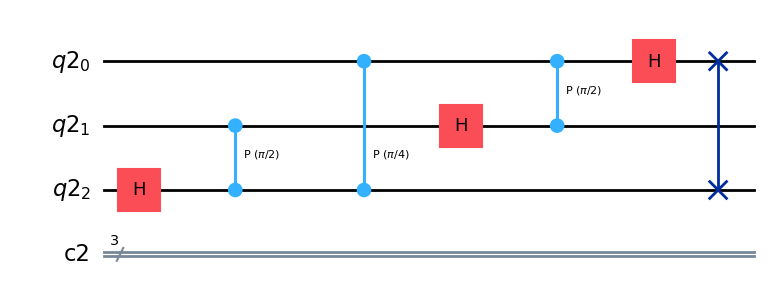

In [24]:
qc.swap(0, 2)

qc.draw(output="mpl")

例として、$|5\rangle$にQFTを施してみましょう。

まず、整数5のバイナリが量子回路にエンコードされているかを確認します。



In [25]:
bin(5)

'0b101'

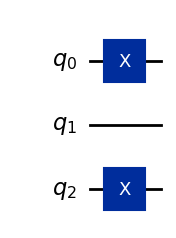

In [26]:
qc = QuantumCircuit(3)

qc.x(0)
qc.x(2)
qc.draw(output="mpl")

Aerシミュレータによって量子状態をチェックします：



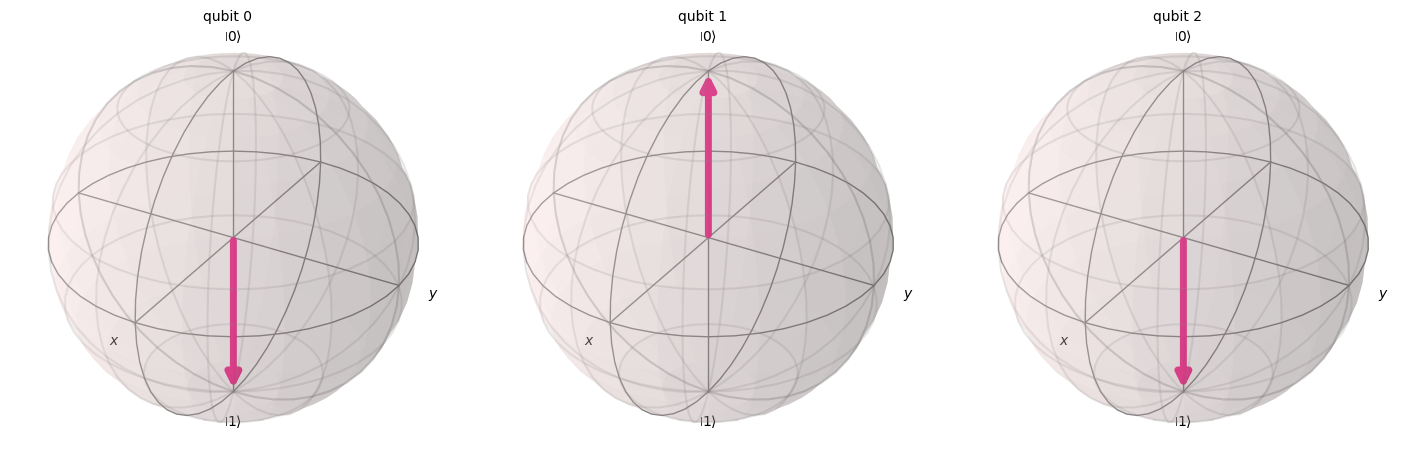

In [27]:
statevector = Statevector(qc)
plot_bloch_multivector(statevector)

最後に、QFTを施して終状態を見てみましょう：

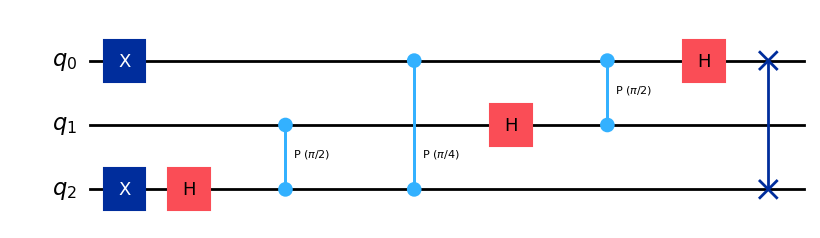

In [28]:
qc.h(2)
qc.cp(pi / 2, 1, 2)
qc.cp(pi / 4, 0, 2)

qc.h(1)
qc.cp(pi / 2, 0, 1)

qc.h(0)

qc.swap(0, 2)

qc.draw(output="mpl")

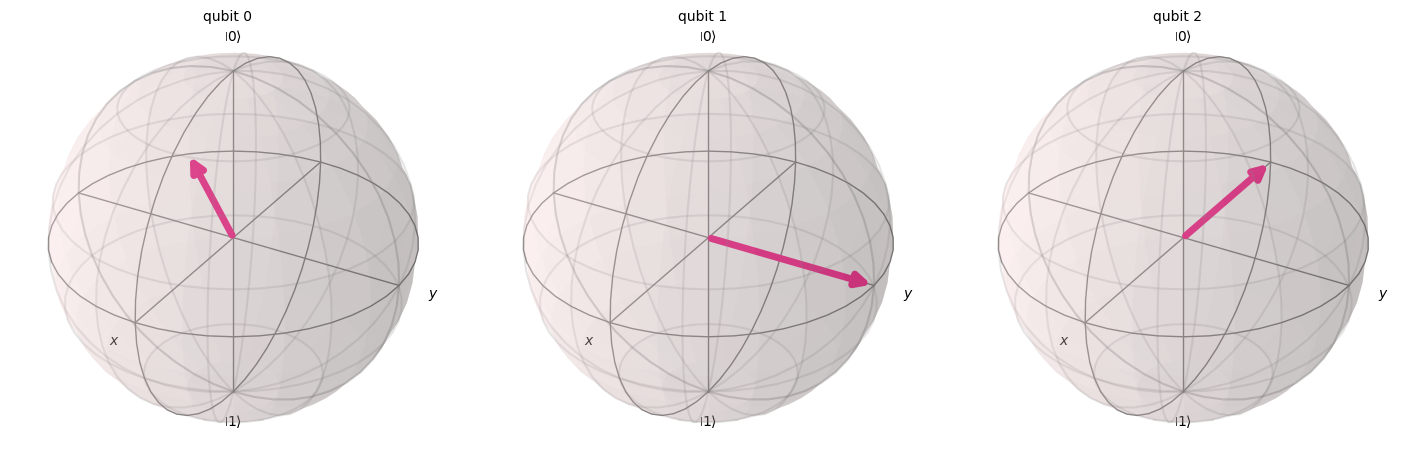

In [29]:
statevector = Statevector(qc)
plot_bloch_multivector(statevector)

QFTが正しく機能したことを確認できました。量子ビット0は一周の$\tfrac{5}{8}$倍、量子ビット1は一周の$\tfrac{10}{8}$倍、量子ビット2は$\tfrac{20}{8}$倍の角度となっています。


### 2.5 エクササイズ: QFT



(1) 4量子ビットのQFTを実装しましょう。



In [13]:
##your code goes here##

(2) $|14\rangle$にQFTを施し、Bloch球を用いて図示してみましょう。


In [14]:
##your code goes here##

#### エクササイズの回答：QFT


(1)



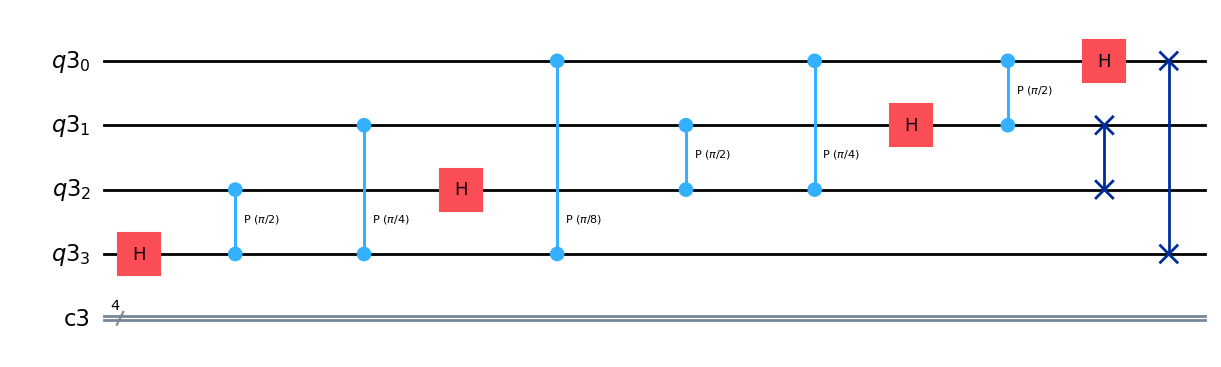

In [30]:
qr = QuantumRegister(4)
cr = ClassicalRegister(4)
qc = QuantumCircuit(qr, cr)

qc.h(3)
qc.cp(pi / 2, 2, 3)
qc.cp(pi / 4, 1, 3)
qc.cp(pi / 8, 0, 3)

qc.h(2)
qc.cp(pi / 2, 1, 2)
qc.cp(pi / 4, 0, 2)

qc.h(1)
qc.cp(pi / 2, 0, 1)

qc.h(0)

qc.swap(0, 3)
qc.swap(1, 2)

qc.draw(output="mpl")

(2)



In [16]:
bin(14)

'0b1110'

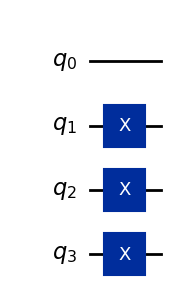

In [31]:
qc = QuantumCircuit(4)

qc.x(1)
qc.x(2)
qc.x(3)
qc.draw("mpl")

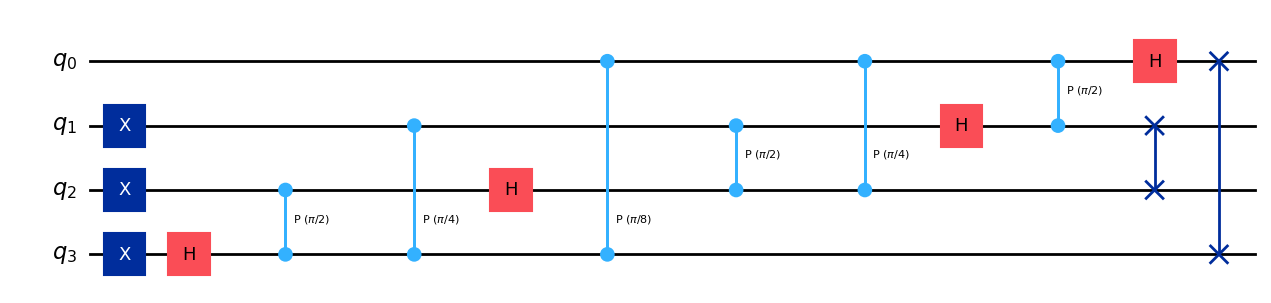

In [32]:
qc.h(3)
qc.cp(pi / 2, 2, 3)
qc.cp(pi / 4, 1, 3)
qc.cp(pi / 8, 0, 3)

qc.h(2)
qc.cp(pi / 2, 1, 2)
qc.cp(pi / 4, 0, 2)

qc.h(1)
qc.cp(pi / 2, 0, 1)
qc.h(0)

qc.swap(0, 3)
qc.swap(1, 2)

qc.draw(output="mpl")

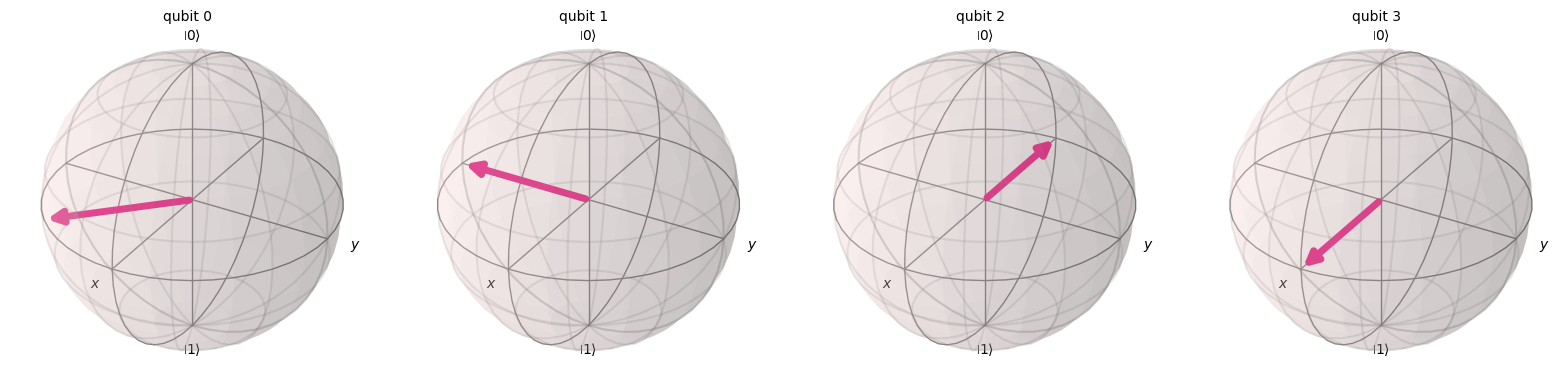

In [33]:
statevector = Statevector(qc)
plot_bloch_multivector(statevector)

## 3. 量子位相推定（QPE）の基本


QPEアルゴリズムは、あるユニタリ行列$U$に対し$U\vert\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$を満たす$\theta$を推定します。ここで$U$はユニタリであるから、その固有値の絶対値は1であることに注意します。


### 3.1 手順



#### 1. 準備

量子状態$\vert\psi\rangle$をある一連の量子ビットレジスタに格納しておきます。これに加え、追加の$n$量子ビットを、$2^n\theta$の値を格納するための計算レジスタとして用意しておきます。
$$
|\psi_0\rangle = \lvert 0 \rangle^{\otimes n} \lvert \psi \rangle
$$



#### 2. 重ね合わせ

計算レジスタの$n$ビット全てに対するアダマールゲート$H^{\otimes n}$を作用させます。

$$
|\psi_1\rangle = {\frac {1}{2^{\frac {n}{2}}}}\left(|0\rangle +|1\rangle \right)^{\otimes n} \lvert \psi \rangle
$$


#### 3. ユニタリ演算子と制御ユニタリ演算

$U$は$|\psi\rangle$を固有状態にもつユニタリ演算子であるから、実数$\theta$を用いて$U|\psi \rangle =e^{\boldsymbol{2\pi i} \theta }|\psi \rangle$と書けます。そのため、$U$を$|\psi\rangle$に$2^j$回かけると、：

$$
U^{2^{j}}|\psi \rangle =U^{2^{j}-1}U|\psi \rangle =U^{2^{j}-1}e^{2\pi i\theta }|\psi \rangle =\cdots =e^{2\pi i2^{j}\theta }|\psi \rangle
$$

また、ユニタリ演算子$U$についての制御ユニタリ演算$CU$を考えましょう。これは、制御ビットの値が$|1\rangle$のときのみユニタリ演算子$U$が標的ビットにかかるものです。ここで制御ビットの状態が$|+\rangle$のケースを考えると、：

$$
CU|\psi\rangle|+\rangle=CU|\psi\rangle(\dfrac{1}{\sqrt{2}}(|0\rangle+|1\rangle))=\dfrac{1}{\sqrt{2}}(|\psi\rangle|0\rangle+U|\psi\rangle|1\rangle)=\dfrac{1}{\sqrt{2}}(|\psi\rangle|0\rangle+e^{\boldsymbol{2\pi i} \theta }|\psi\rangle|1\rangle)
$$


### 3.2 例：$T$ゲートに対するQPE



例として、$T$ゲートに対してQPEを適用しましょう。

$$
T|1\rangle =
\begin{pmatrix}
1 & 0\\
0 & e^\frac{i\pi}{4}\\
\end{pmatrix}
\begin{pmatrix}
0\\
1\\
\end{pmatrix}
= e^\frac{i\pi}{4}|1\rangle
$$

です。ここで、

$$
T|1\rangle = e^{2i\pi\theta}|1\rangle
$$

に対する量子位相推定を実行して

$$
\theta = \frac{1}{8}
$$

を求められるでしょうか。



まずは$X$ゲートによって、$\vert\psi\rangle = \vert1\rangle$ で初期化しましょう：



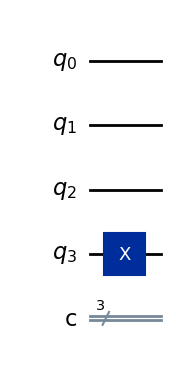

In [43]:
qpe = QuantumCircuit(4, 3)
qpe.x(3)
qpe.draw(output="mpl")

続けて、アダマールゲートを計算ビットに適用します：


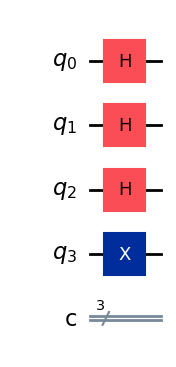

In [44]:
for qubit in range(3):
    qpe.h(qubit)
qpe.draw(output="mpl")

制御ユニタリ演算を実行します：


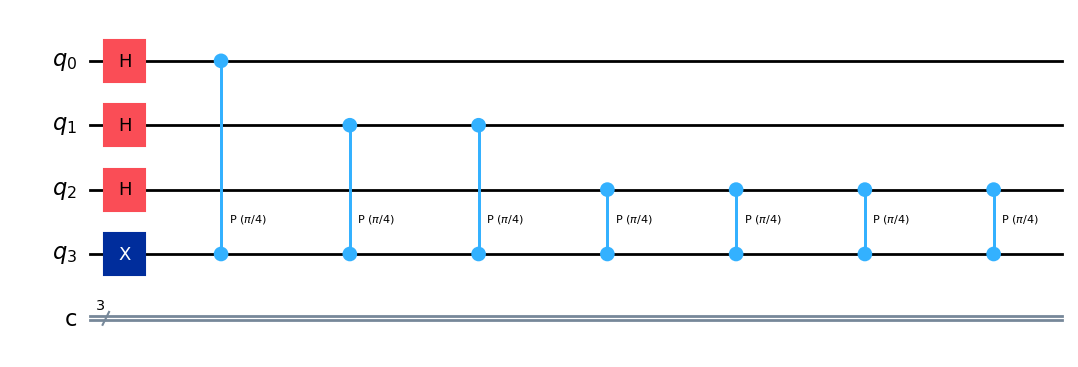

In [45]:
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(pi / 4, counting_qubit, 3)  # This is C-U
    repetitions *= 2
qpe.draw(output="mpl")

最後に計算レジスタに対して逆QFTを作用させ、測定してみましょう：


In [2]:
from qiskit.circuit.library import QFT

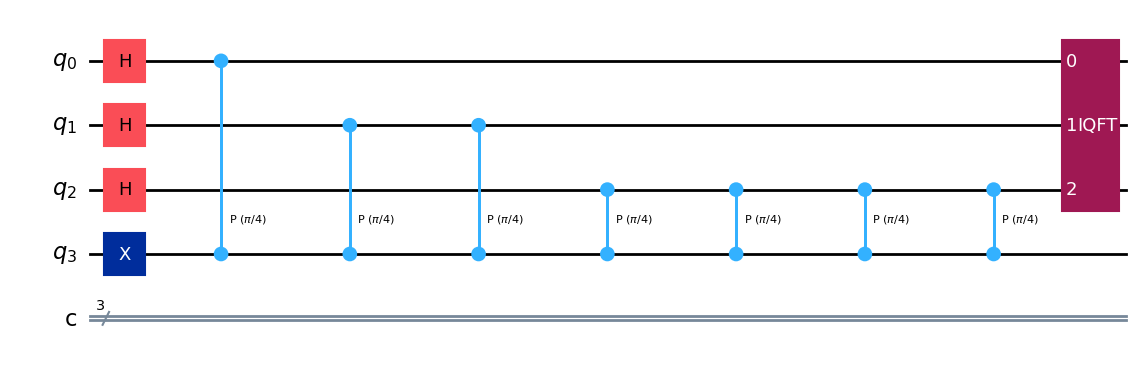

In [ ]:
# Apply inverse QFT
qpe.append(QFT(3, inverse=True), [0, 1, 2])
qpe.draw(output="mpl")

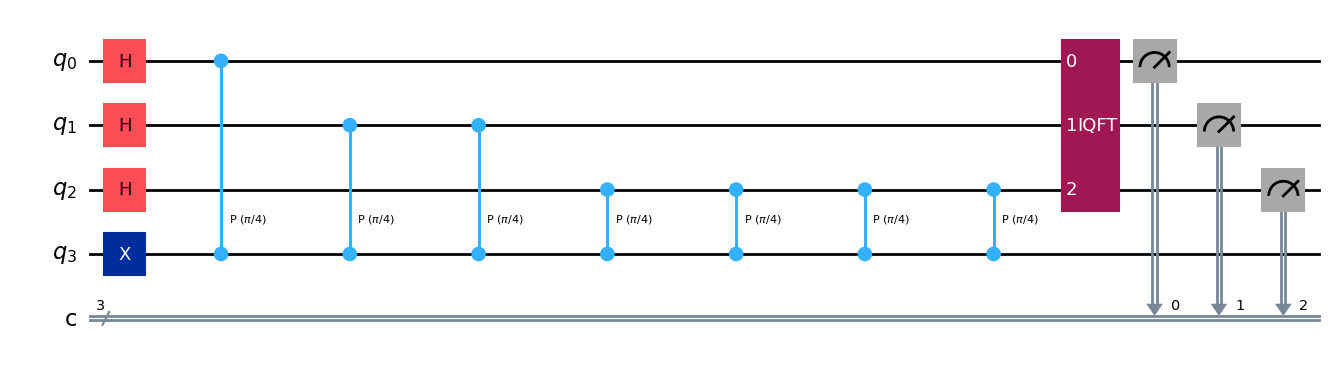

In [48]:
for n in range(3):
    qpe.measure(n, n)
qpe.draw(output="mpl")

Aerシミュレータによって、実行してみましょう：


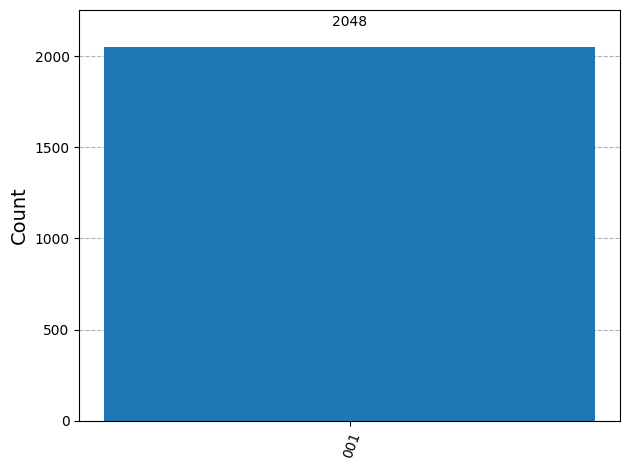

In [49]:
aer_sim = AerSimulator()
shots = 2048

pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
t_qpe = pm.run(qpe)

sampler = Sampler(mode=aer_sim)
job = sampler.run([t_qpe], shots=shots)
result = job.result()
answer = result[0].data.c.get_counts()

plot_histogram(answer)

終状態は(`001`)で確定しています。これは整数`1`を表現し、これを$2^n$で割ることによって$\theta$を得ます:

$$
\theta = \frac{1}{2^3} = \frac{1}{8}
$$



Shorのアルゴリズムは、量子回路に埋め込まれている未知の$\theta$を推定することを通して、素因数分解を行います。


### 3.3 エクササイズ

計算レジスタに3量子ビットを、固有状態に1量子ビットを用いて、$\theta = 1/3$を推定してみましょう。

$P|1\rangle = e^{i\lambda}|1\rangle$であるので、ここで$\lambda = \tfrac{2 \pi}{3}$と設定することで、$U|1\rangle = e^{2\pi i \tfrac{1}{3}}|1\rangle$となります。



In [10]:
##your code goes here##

#### エクササイズの解: $\theta = 1/3$



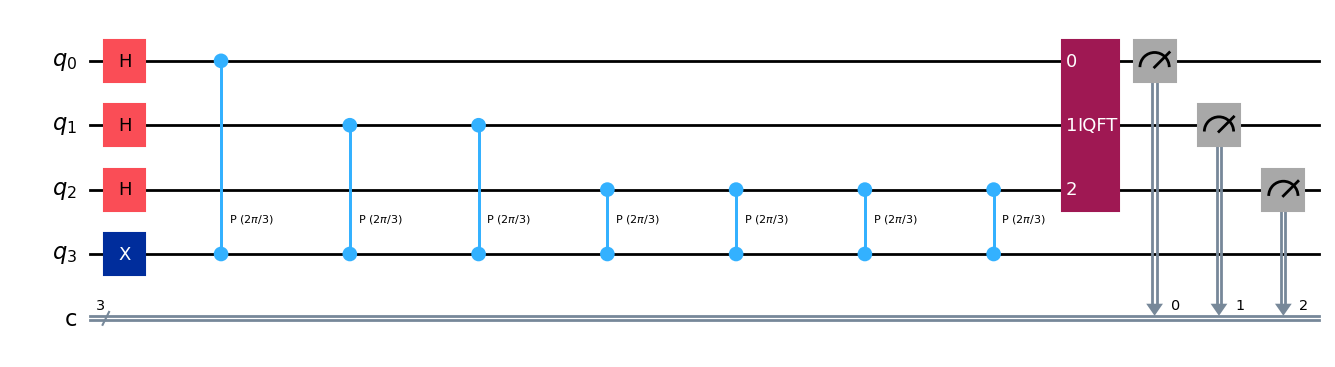

In [ ]:
# Create and set up circuit
qpe = QuantumCircuit(4, 3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe.h(qubit)

# Prepare our eigenstate |psi>:
qpe.x(3)

# Do the controlled-U operations:
angle = 2 * pi / 3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(angle, counting_qubit, 3)
    repetitions *= 2

# Do the inverse QFT:
qpe.append(QFT(3, inverse=True), [0, 1, 2])

for n in range(3):
    qpe.measure(n, n)

qpe.draw(output="mpl")

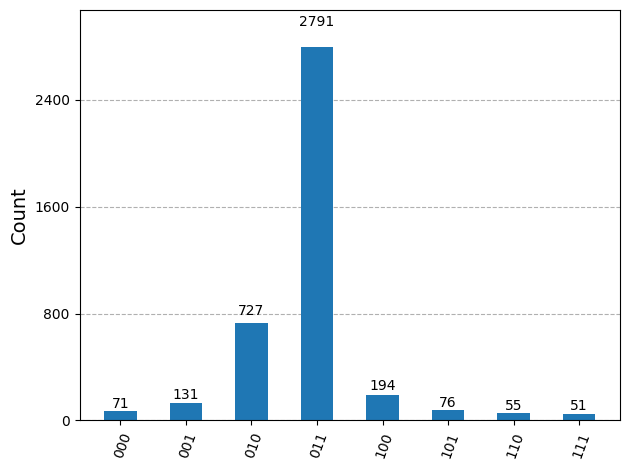

In [52]:
aer_sim = AerSimulator()
shots = 4096

pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=1)
t_qpe = pm.run(qpe)

sampler = Sampler(mode=aer_sim)
job = sampler.run([t_qpe], shots=shots)
result = job.result()
answer = result[0].data.c.get_counts()

plot_histogram(answer)

## 4. Qiskit Runtime Sampler primitiveによる実行

Qiskit Patternsとして以下の4ステップを実行し、QPEを本物の量子デバイスで実行してみましょう。

1.  問題を量子ネイティブな形式に落とし込む
2.  回路を最適化する
3.  量子回路を実行する
4.  結果の後処理を行う


In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Sampler

In [ ]:
# Loading your IBM Quantum account(s)

service = QiskitRuntimeService()

### 4.1 Step 1: 問題を量子回路へ落とし込む



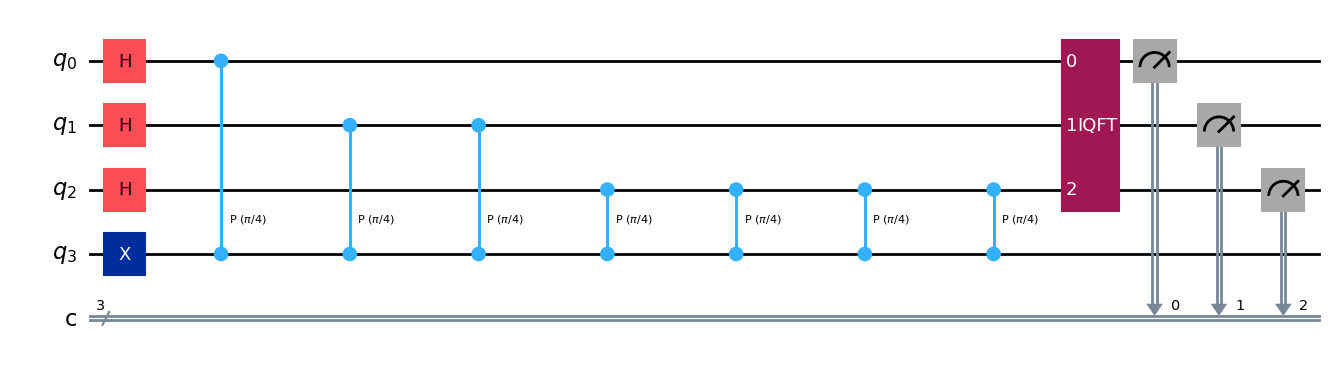

In [ ]:
qpe = QuantumCircuit(4, 3)
qpe.x(3)
for qubit in range(3):
    qpe.h(qubit)
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(pi / 4, counting_qubit, 3)  # This is C-U
    repetitions *= 2
qpe.append(QFT(3, inverse=True), [0, 1, 2])
for n in range(3):
    qpe.measure(n, n)
qpe.draw(output="mpl")

In [15]:
backend = service.least_busy(simulator=False, operational=True, min_num_qubits=4)

print(backend)

<IBMBackend('ibm_torino')>


### 4.2 Step 2: ターゲットのハードウェアに対して最適化する



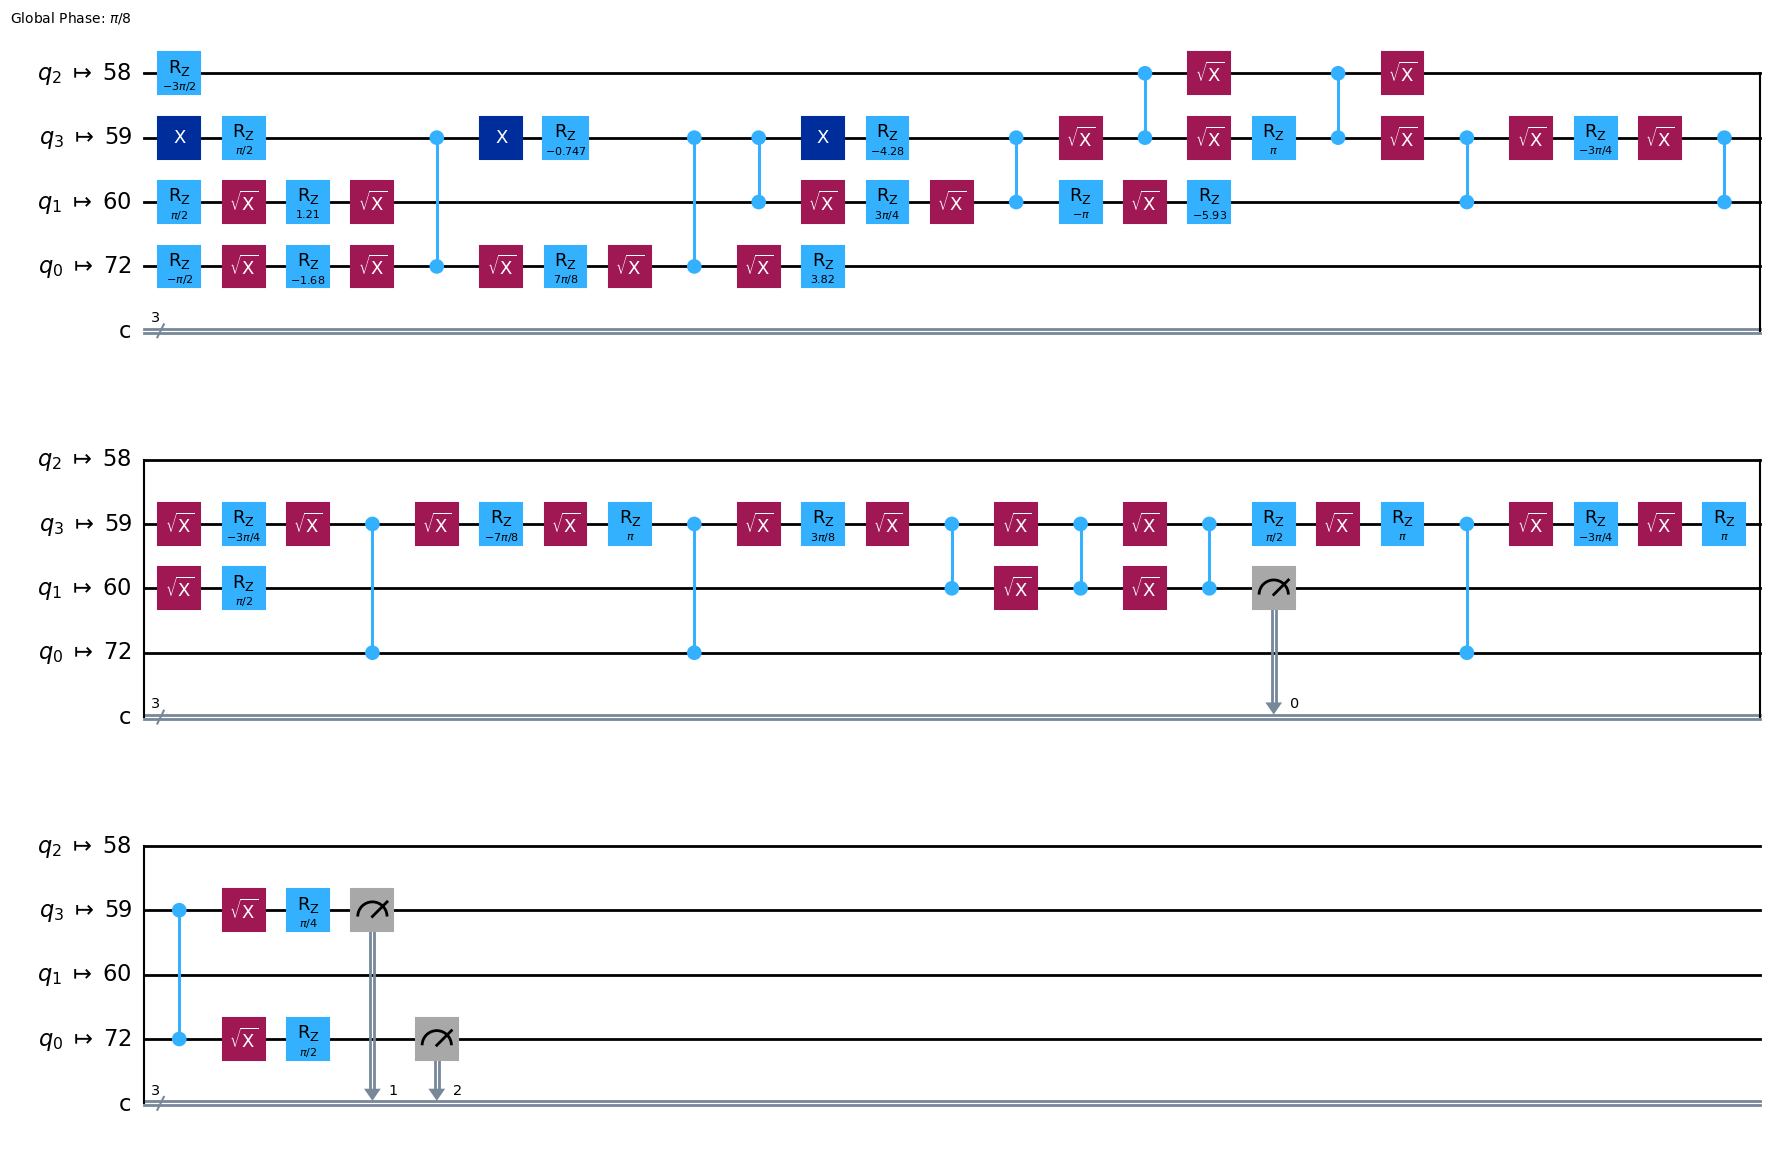

In [16]:
# Transpile the circuit into basis gates executable on the hardware
pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
qc_compiled = pm.run(qpe)

qc_compiled.draw("mpl", idle_wires=False)

### 4.3 Step 3: ターゲットのハードウェアで実行する



In [ ]:
real_sampler = Sampler(mode=backend)
job = real_sampler.run([qc_compiled], shots=1024)
job_id = job.job_id()
print("job id:", job_id)

In [18]:
job = service.job(job_id)  # Input your job-id between the quotations
job.status()

'DONE'

In [ ]:
result_real = job.result()
print(result_real)

### 4.4 Step 4: 結果の後処理をする



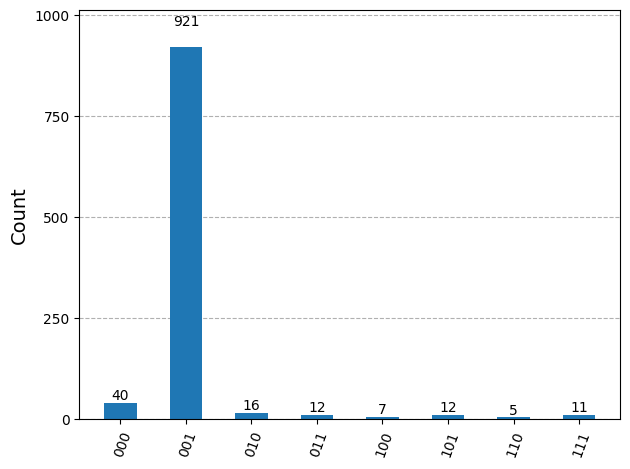

In [20]:
from qiskit.visualization import plot_histogram

plot_histogram(result_real[0].data.c.get_counts())

In [21]:
# See the version of Qiskit
import qiskit

qiskit.__version__

'2.1.0'

© IBM Corp., 2017-2025